##### Импорт библиотек

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc as sk_auc
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.special import expit

In [36]:
df = pd.read_csv("data/ready data.csv")

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   comment                         1800 non-null   object 
 1   rating                          1800 non-null   float64
 2   Вопрос не решен                 1800 non-null   int64  
 3   Вопрос решен                    1800 non-null   int64  
 4   Не понравилось качество услуги  1800 non-null   int64  
 5   Не понравился результат услуги  1800 non-null   int64  
 6   Понравилась работа сотрудников  1800 non-null   int64  
 7   Понравилась скорость работы     1800 non-null   int64  
 8   Понравилось качество услуги     1800 non-null   int64  
 9   Понравился результат услуги     1800 non-null   int64  
 10  Претензии и предложения         1800 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 154.8+ KB


(                                        comment  rating  Вопрос не решен  \
 0                                       спасибо     5.0                0   
 1                                      спасибо!     5.0                0   
 2                                      Отлично      5.0                0   
 3  Благодарю за оперативное решение проблемы !      5.0                0   
 4         Прекрасный специалист! Побольше таких     5.0                0   
 
    Вопрос решен  Не понравилось качество услуги  \
 0             1                               0   
 1             1                               0   
 2             0                               0   
 3             1                               0   
 4             0                               0   
 
    Не понравился результат услуги  Понравилась работа сотрудников  \
 0                               0                               0   
 1                               0                               0   
 2          

##### Фмльтруем пустые строки и строки без меток, преобразуем текст в числовой вид и разбиваем с сохранением распределения меток

In [37]:
X_raw = df["comment"]
y = df.iloc[:, 3:]

mask = X_raw.notnull() & (X_raw.str.strip() != "")
X_raw = X_raw[mask]
y = y[mask]

# Приводим метки к числам
y = y.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X_raw)
X = X.toarray()
y_array = y.values.astype(int)

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y_array, test_size=0.3
)

X_train_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_train).all(axis=1)))].reset_index(drop=True)
X_test_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_test).all(axis=1)))].reset_index(drop=True)

##### Обучаем модель, делаем предсказание на тесте и выводим результаты по меткам

In [38]:
model = MultiOutputClassifier(LogisticRegression(max_iter=2000, class_weight='balanced'))
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

print("\nLogistic Regression")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values = []
f1_values = []

for i, col in enumerate(y.columns):
    try:
        auc = roc_auc_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        print(f"{col:<40} {auc:>10.3f} {f1:>10.3f}")
        roc_auc_values.append(auc)
        f1_values.append(f1)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values:
    avg_roc_auc = np.mean(roc_auc_values)
    avg_f1 = np.mean(f1_values)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc:>10.3f} {avg_f1:>10.3f}")

joblib.dump(model, "logistic_model.pkl")


Logistic Regression
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.738      0.719
Не понравилось качество услуги                0.695      0.357
Не понравился результат услуги                0.691      0.333
Понравилась работа сотрудников                0.809      0.694
Понравилась скорость работы                   0.904      0.894
Понравилось качество услуги                   0.796      0.693
Понравился результат услуги                   0.716      0.579
Претензии и предложения                       0.856      0.652
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.776      0.615


['logistic_model.pkl']

In [39]:
param_grid_svc = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__class_weight': ['balanced'],
    'estimator__max_iter': [10000]
}

# Базовая модель
base_svc = OneVsRestClassifier(LinearSVC())

# GridSearch
grid_search_svc = GridSearchCV(
    estimator=base_svc,
    param_grid=param_grid_svc,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучение с подбором параметров
grid_search_svc.fit(X_train, y_train)

# Лучшая модель
svc_model = grid_search_svc.best_estimator_

# Предсказания
y_pred_svc = svc_model.predict(X_test)

print("\nLinear SVC")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_svc = []
f1_values_svc = []
labels_svc = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred_svc[:, i])
        f1 = f1_score(y_test[:, i], y_pred_svc[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_svc.append(auc_val)
        f1_values_svc.append(f1)
        labels_svc.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_svc:
    avg_roc_auc_svc = np.mean(roc_auc_values_svc)
    avg_f1_svc = np.mean(f1_values_svc)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_svc:>10.3f} {avg_f1_svc:>10.3f}")

# Получаем decision_function (shape [n_samples, n_classes])
y_scores = svc_model.decision_function(X_test)

# Применяем сигмоиду для перевода в вероятности
y_proba_svc = expit(y_scores)

# Сохранение модели
joblib.dump(svc_model, "linear_svc_model.pkl")

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Linear SVC
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.737      0.716
Не понравилось качество услуги                0.720      0.407
Не понравился результат услуги                0.665      0.291
Понравилась работа сотрудников                0.810      0.694
Понравилась скорость работы                   0.901      0.890
Понравилось качество услуги                   0.783      0.673
Понравился результат услуги                   0.720      0.586
Претензии и предложения                       0.854      0.642
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.774      0.612


['linear_svc_model.pkl']

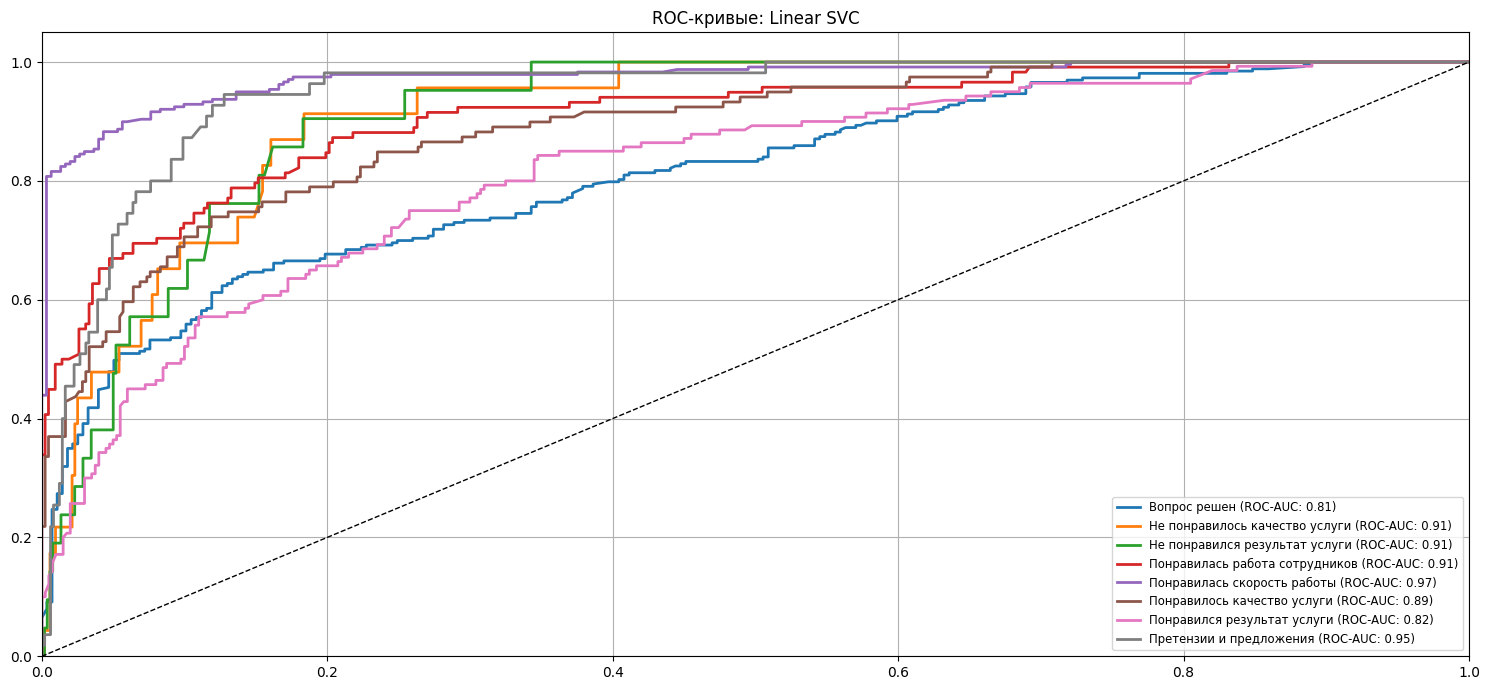

In [41]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba_svc[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Linear SVC')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Naive Bayes (MultinomialNB)
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос решен                                  0.689      0.683
Не понравилось качество услуги                0.698      0.377
Не понравился результат услуги                0.670      0.320
Понравилась работа сотрудников                0.772      0.667
Понравилась скорость работы                   0.839      0.827
Понравилось качество услуги                   0.720      0.577
Понравился результат услуги                   0.675      0.519
Претензии и предложения                       0.835      0.690
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.737      0.582


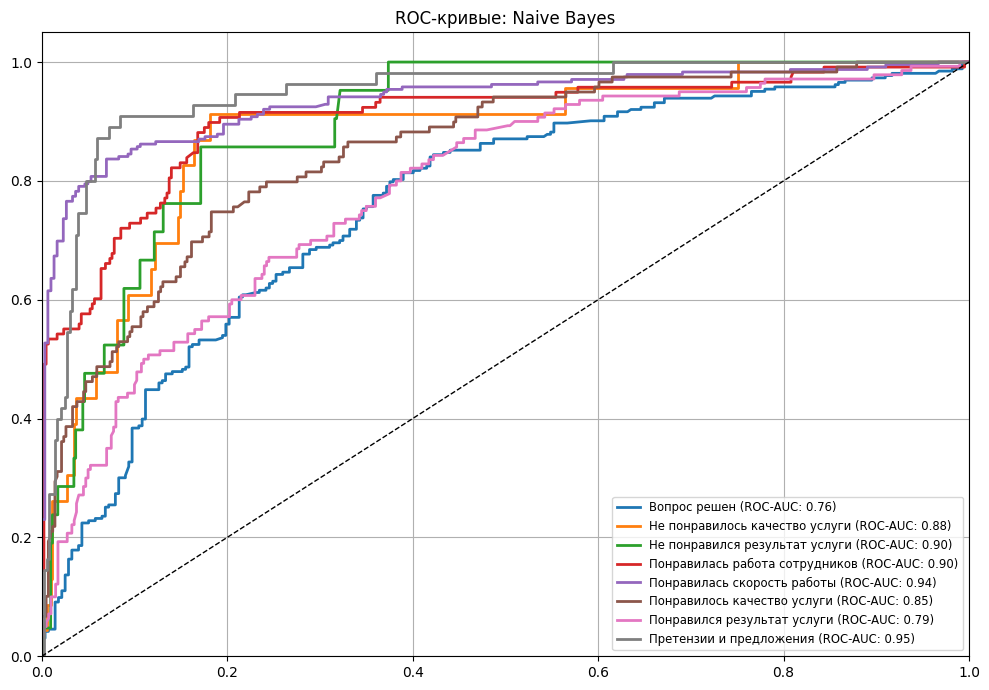

Категории, выставленные моделью:
 - Вопрос решен
 - Скорость выполненной работы
Категории, выставленные моделью:
 - Вопрос решен
 - Скорость выполненной работы
Категории, выставленные моделью:
 - Скорость выполненной работы
Категории, выставленные моделью:
 - Скорость выполненной работы
 - Не понравился результат
Категории, выставленные моделью:
Категории, выставленные моделью:
 - Вопрос решен
 - Скорость выполненной работы
Категории, выставленные моделью:
 - Вопрос решен
 - Скорость выполненной работы


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc as sk_auc
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Параметры для MultinomialNB (не так много для подбора)
param_grid = {
    'estimator__alpha': [0.1, 0.5, 1.0],  # сглаживание Лапласа
    'estimator__fit_prior': [True, False]
}

# Оборачиваем MultinomialNB в MultiOutputClassifier
base_model = MultiOutputClassifier(MultinomialNB())

# GridSearchCV с подбором параметров
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучаем с подбором параметров
grid_search.fit(X_train, y_train)

# Используем лучшую модель
model = grid_search.best_estimator_

# Предсказания
y_pred = model.predict(X_test)

print("\nNaive Bayes (MultinomialNB)")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values = []
f1_values = []
labels = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values.append(auc_val)
        f1_values.append(f1)
        labels.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values:
    avg_roc_auc = np.mean(roc_auc_values)
    avg_f1 = np.mean(f1_values)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc:>10.3f} {avg_f1:>10.3f}")

# Предсказания вероятностей
y_proba_raw = model.predict_proba(X_test)
y_proba = np.array([proba[:, 1] for proba in y_proba_raw]).T

# Сохраняем модель
joblib.dump(model, "naive_bayes_model.pkl")

# Визуализация ROC-кривых
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Naive Bayes')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Функция для предсказания на новых текстах (пример)
def predict_labels(text):
    X = vectorizer.transform([text])
    preds = model.predict(X)
    preds = preds[0]
    
    labels = ['Вопрос не решен',
    'Вопрос решен',
    'Не понравилось качество услуги',
    'Не понравился результат услуги',
    'Понравилась работа сотрудников',
    'Понравилась скорость работы',
    'Понравилось качество услуги',
    'Понравился результат услуги',
    'Претензии и предложения']
    
    result = {label: bool(pred) for label, pred in zip(labels, preds)}
    return result

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")
